In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn import linear_model
from sklearn.metrics import log_loss

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score
from scipy.sparse import hstack




In [5]:
import re
import string
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Phoebe\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [6]:
train_csv = pd.read_csv('train.csv', error_bad_lines=False).fillna(' ')
test_csv = pd.read_csv('test.csv', error_bad_lines=False).fillna(' ')
display(train_csv.head())

,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate
0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0
1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0
2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0
3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0
4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0


In [8]:
#aggregation of toxic labels
train = train_csv
train['general_toxic'] = ((train['toxic'] + train['severe_toxic'] + train['obscene'] + train['threat'] + train['insult'] + train['identity_hate']) > 0).astype(int)
train = train.drop(columns=['toxic', 'severe_toxic', 'severe_toxic', 'threat', 'insult', 'identity_hate', 'obscene'])
display(train[200:250].head()) 

,id,comment_text,general_toxic
200,007f127033d66db5,"""\n\n Link to Sacramento \n\nI placed a wikipe...",0
201,007f1839ada915e6,Your blatant POV pushing \n\nNeither of you gu...,1
202,00803f08f55bdcad,"""\nReliable sources indicate otherwise. Please...",0
203,008198c5a9d85a8e,"I did research thank you very much, and it is ...",0
204,00822d0d01752c7e,"""\n\nA """"TotallyDisputed"""" notice would probab...",0


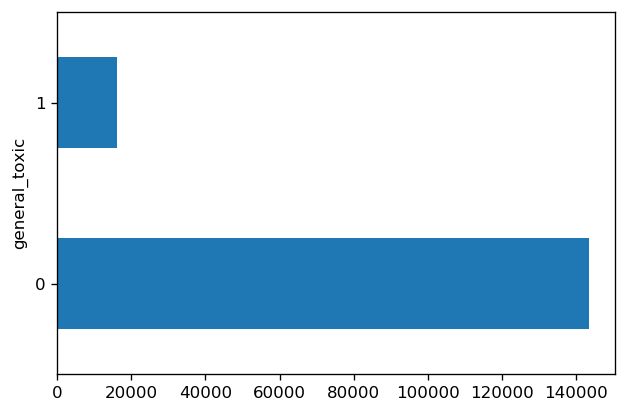

In [9]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(6,4), dpi=120)
train.groupby('general_toxic')['general_toxic'].count().plot(kind='barh', ax=ax)
